# Deep dive into Grover's search algorithm

In [1]:
import matplotlib.pyplot as plt
import qsharp

Preparing Q# environment...


## Task 1. Calculate the number of valid 3-colorings of the graph, as well as the search space size for both of your algorithm implementations, for Australia and Spain

![WhatsApp Image 2024-04-13 at 13.40.17_38bbec2d.jpg](<attachment:WhatsApp Image 2024-04-13 at 13.40.17_38bbec2d.jpg>)
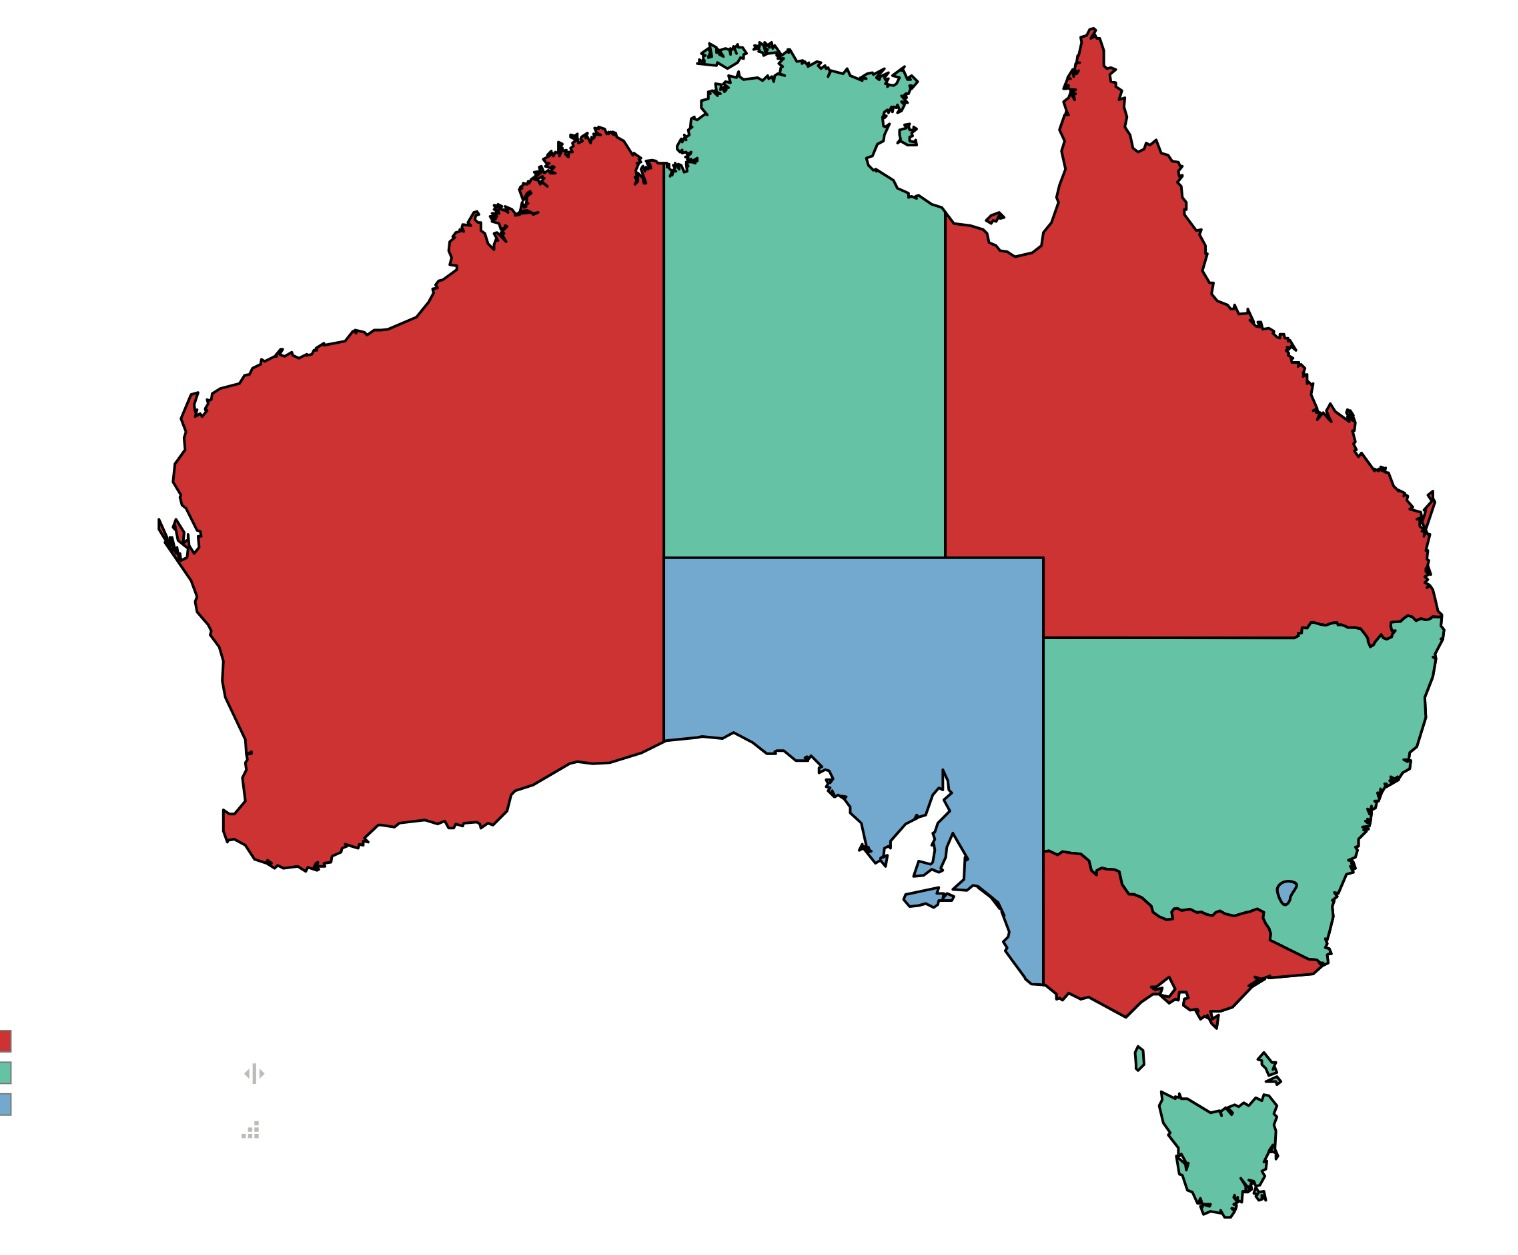

In [36]:
australia = {
    "WA": ["NT", "SA"],
    "NT": ["WA", "SA", "QLD"],
    "SA": ["WA", "NT", "QLD", "NSW", "VIC"],
    "QLD": ["NT", "SA", "NSW"],
    "NSW": ["QLD", "SA", "VIC"],
    "VIC": ["SA", "NSW"],
    "TAS": []  # Tasmania does not border any state
}


In [38]:
spain = {
    "Galicia": ["Asturias", "Castilla y Leon"],
    "Asturias": ["Galicia", "Castilla y Leon"],
    "Castilla y Leon": ["Galicia", "Asturias", "Madrid", "Castilla La Mancha", "Extremadura"],
    "Madrid": ["Castilla y Leon", "Castilla La Mancha"],
    "Castilla La Mancha": ["Madrid", "Castilla y Leon", "Extremadura", "Valencia", "Andalusia"],
    "Extremadura": ["Castilla y Leon", "Castilla La Mancha", "Andalusia"],
    "Andalusia": ["Extremadura", "Castilla La Mancha", "Valencia"],
    "Valencia": ["Andalusia", "Castilla La Mancha"]
}


In [39]:
def is_valid(graph, colors):
    for node, neighbours in graph.items():
        if any(colors[node] == colors[neighbour] for neighbour in neighbours if neighbour in colors):
            return False
    return True

def color_graph(graph, colors, nodes, index=0, color_options=['Red', 'Green', 'Blue']):
    if index == len(nodes):
        return 1 if is_valid(graph, colors) else 0
    
    num_valid_colorings = 0
    for color in color_options:
        colors[nodes[index]] = color
        num_valid_colorings += color_graph(graph, colors, nodes, index + 1, color_options)
        del colors[nodes[index]]
    
    return num_valid_colorings

def calculate_colorings(graph):
    nodes = list(graph.keys())
    return color_graph(graph, {}, nodes)

# Calculate valid colorings and search space sizes
australia_colorings = calculate_colorings(australia)
spain_colorings = calculate_colorings(spain)

# Search space sizes
brute_force_australia = 3 ** len(australia)
brute_force_spain = 3 ** len(spain)

print(f"Valid 3-colorings for Australia: {australia_colorings}, Search space size (brute force): {brute_force_australia}")
print(f"Valid 3-colorings for Spain: {spain_colorings}, Search space size (brute force): {brute_force_spain}")


Valid 3-colorings for Australia: 18, Search space size (brute force): 2187
Valid 3-colorings for Spain: 12, Search space size (brute force): 6561


In [2]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;

// Utility to convert integer to Boolean array (little-endian)
function IntAsBoolArray(value : Int, size : Int) : Bool[] {
    mutable result = new Bool[size];
    for i in 0 .. size - 1 {
        set result w/= i <- (value &&& (1 <<< i)) != 0;
    }
    return result;
}


/snippet_.qs(6,22): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.


In [5]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;
// Initialize the quantum register with all possible 3-color states
operation InitializeRegister(N : Int) : Qubit[] {
    use register = Qubit[2 * N];
    ApplyToEach(H, register);
    return register;
}


In [6]:
%%qsharp
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Diagnostics;
    operation ColorEqualityOracle_Nbit(c0 : Qubit[], c1 : Qubit[], target : Qubit) : Unit is Adj+Ctl {
        within {
            for (q0, q1) in Zipped(c0, c1) {
                // compute XOR of q0 and q1 in place (storing it in q1)
                CNOT(q0, q1);
            }
        } apply {
            // if all XORs are 0, the bit strings are equal
            (ControlledOnInt(0, X))(c1, target);
        }
    }

In [7]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;
// Define the Oracle for checking valid colorings
operation Oracle(register : Qubit[], edges : (Int, Int)[]) : Unit is Adj+Ctl {
    use ancilla = Qubit();
        for edge in edges {
            let (start, end) = edge;
            within {
                ColorEqualityOracle_Nbit(
                    register[2 * start .. 2 * start + 1],
                    register[2 * end .. 2 * end + 1],
                    ancilla);
            } apply {
                Z(ancilla);
            }
        }
}

In [8]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;
// Define the Grover Diffusion Operator
operation GroverDiffusion(register : Qubit[]) : Unit {
    ApplyToEach(H, register);
    ApplyToEach(X, register);
    Controlled Z(Most(register), Tail(register));
    ApplyToEach(X, register);
    ApplyToEach(H, register);
}


In [9]:
%%qsharp
// Full Grover iteration combining the Oracle and the diffusion operator
operation GroverIteration(register : Qubit[], edges : (Int, Int)[], numIterations : Int) : Unit {
    for idx in 1 .. numIterations {
        Oracle(register, edges);
        GroverDiffusion(register);
    }
}


In [17]:
%%qsharp
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Diagnostics;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Characterization;
open Microsoft.Quantum.Oracles;

operation MeasureColor_Reference(register : Qubit[]) : Int {
        return ResultArrayAsInt(MultiM(register));
    }
// Measure the register and convert to an integer array of colors
operation MeasureColoring(register : Qubit[]) : Int[] {
    let N = Length(register) / 2;
    mutable results = new Int[N];
    for i in 0 .. N - 1{
        set results w/= i <- MeasureColor_Reference(register[2 * i .. 2 * i + 1]);
    }
    return results;
}


/snippet_.qs(18,23): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.


In [29]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;

// Main entry point
@EntryPoint()
operation SolveGraphColoring() : Int[] {
    let nodes = 4;  // WA, NT, SA, QLD
    let edges = [(0, 1), (1, 2), (2, 3)];  // Path graph
    let register = InitializeRegister(nodes);
    let numIterations = 2;  // sqrt(N), adjust based on your actual graph size and testing

    GroverIteration(register, edges, numIterations);
    let result = MeasureColoring(register);
    Message($"Coloring result: {result}");
    return result;
    }


In [35]:
import qsharp
result = SolveGraphColoring.simulate()

Source,Callable
/snippet_40acb93f-75e4-4a6d-a2bc-f14e10a95f66.qs:0,InitializeRegister
(notebook),SolveGraphColoring


Released qubits are not in zero state.
